<a href="https://colab.research.google.com/github/Murcha1990/AppliedDS_DPO_2024/blob/main/Lesson3_NLP3/AiEdu_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NER и лингвомодели

Cегодня поговорим об одной из самых популярных задач NLP – извлечении именованных сущностей (Named-entity recognition, NER).







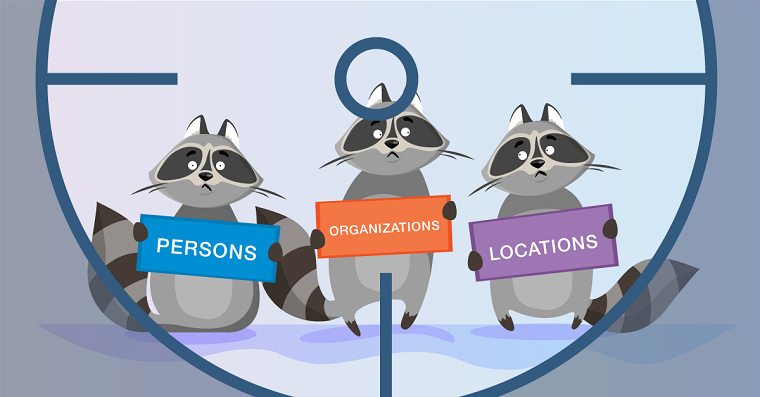

Первая задача, с решения которой начинается процесс работы каждой NLP системы, это необходимость максимально детального разбора пользовательского запроса и извлечения из него всей доступной в нем информации.  
  
NLP система должна:  
    1) Разбить текст запроса на составляющие (слова, токены)  
    2) Привести их в базовую форму (леммы, стеммы). Получить, если это необходимо, сведения о частях речи и прочую низкоуровневую информацию.  
    3) Распознать слова и словосочетания, то есть вычленить из текста именованные сущности и попытаться извлечь из них так называемые нормализованные значения.  

Этот процесс называется распознаванием именованных сущностей — NER, а модули, занимающиеся их извлечением — компонентами NER.

Допустим, есть новостной текст, и мы хотим выделить в нем сущности (некоторый заранее зафиксированный набор — например, персоны, локации, организации, даты и т.д.)   
Задача NER – понять, что участок текста “июль 1805 года” является датой, “Анна Павловна Шерер” – персоной и т.д.

На входе текст, на выходе структурированные, нормализованные объекты, например, с именами, адресами, датами.

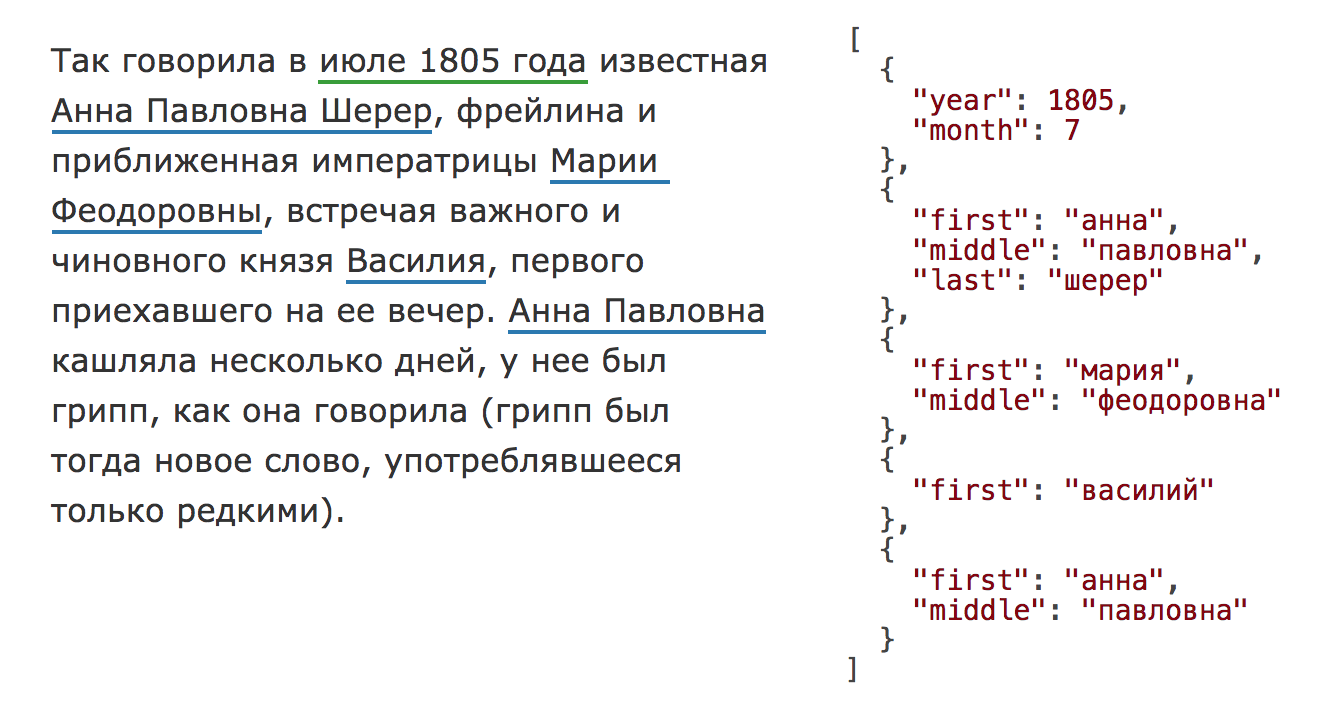

Что такое именованные сущности?  
В первой, классической постановке, которая была сформулирована на конференции MUC-6 в 1995 году, это персоны, локации и организации. С тех пор появилось несколько доступных корпусов, в каждом из которых свой набор именованных сущностей. Обычно к персонам, локациям и организациям добавляются новые типы сущностей.  
Самые распространенные из них — числовые (даты, денежные суммы), а также сущности Misc (от miscellaneous — прочие именованные сущности; пример — iPhone X ).

Для английского языка существует масса коммерческих и открытых решений: Spacy, Stanford NER, OpenNLP, NLTK, MITIE, Google Natural Language API, ParallelDots, Aylien, Rosette, TextRazor.  
Для русского тоже есть хорошие решения, но они в основном закрытые: DaData, Abbyy Infoextractor, Promt и др.
Есть неплохой открытый natasha и deeppavlov

Разберем на практике некоторые из них

## 1 Спарсим случайную статью для анализа

In [ ]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image

import matplotlib.pyplot as plt

In [ ]:
!pip install beautifulsoup4

In [ ]:
import requests
from bs4 import BeautifulSoup
import re

In [ ]:
requests.get("http://rbc.ru/")

<Response [200]>

In [ ]:
%%time
resp=requests.get("https://lenta.ru/news/2021/03/04/new/")
print("cookies:", resp.cookies)
print("time to download:", resp.elapsed)
print("page encoding", resp.encoding)
print("Server response: ", resp.status_code)
print("Is everything ok? ", resp.ok)
print("Page's URL: ", resp.url)

cookies: <RequestsCookieJar[<Cookie is_mobile=0 for .lenta.ru/>, <Cookie lid=vAsAAIGtQGaiNwPCAX8zCAB= for .lenta.ru/>, <Cookie lids=482037A22B6048B9 for .lenta.ru/>]>
time to download: 0:00:02.247296
page encoding utf-8
Server response:  200
Is everything ok?  True
Page's URL:  https://lenta.ru/news/2021/03/04/new/
CPU times: user 86.1 ms, sys: 4.8 ms, total: 90.9 ms
Wall time: 2.82 s


In [ ]:
resp.text[:1000]

'<!DOCTYPE html><html lang="ru"><head><title>Налоги с россиян приготовились собирать по-новому: Госэкономика: Экономика: Lenta.ru</title><meta charset="utf-8" /><meta content="#292929" name="theme-color" /><link href="https://m.lenta.ru/news/2021/03/04/new/" media="only screen and (max-width: 640px)" rel="alternate" /><link href="https://lenta.ru/rss/google-newsstand/main/" rel="alternate" type="application/rss+xml" /><link href="https://lenta.ru/news/2021/03/04/new/" rel="canonical" /><link href="/manifest.json" rel="manifest" /><link rel="shortcut icon" type="image/x-icon" href="https://icdn.lenta.ru/favicon.ico" /><link rel="apple-touch-icon" type="image/x-icon" href="https://icdn.lenta.ru/images/icons/icon-256x256.png" size="256x256" /><link rel="apple-touch-icon" type="image/x-icon" href="https://icdn.lenta.ru/images/icons/icon-192x192.png" size="192x192" /><link rel="apple-touch-icon" type="image/x-icon" href="https://icdn.lenta.ru/images/icons/icon-152x152.png" size="152x152" />

In [ ]:
BeautifulSoup(resp.text, "html5lib").get_text()

'Налоги с россиян приготовились собирать по-новому: Госэкономика: Экономика: Lenta.ru{"@context":"http://schema.org","@type":"NewsArticle","headline":"Налоги с россиян приготовились собирать по-новому","description":"Федеральная налоговая служба (ФНС) приготовилась в течение 2021 года внедрить ряд нововведений, которые позволят собирать налоги с россиян и компаний по-новому, улучшить их администрирование, а также облегчить работу банков по изучению сведений о заемщиках. В частности, появится новая система отслеживания уплаты НДС.","name":"Налоги с россиян приготовились собирать по-новому","alternativeHeadline":"","url":"https://lenta.ru/news/2021/03/04/new/","mainEntityOfPage":{"@type":"WebPage","@id":"https://lenta.ru/news/2021/03/04/new/"},"thumbnailUrl":["https://icdn.lenta.ru/images/2021/03/04/08/20210304085850939/square_1280_db519f1702e1325cf6cc66edca8f1c32.jpg","https://icdn.lenta.ru/images/2021/03/04/08/20210304085850939/wide_4_3_3dec8306eeb93acf24695c77e61c359c.jpg","https://ic

In [ ]:
bs=BeautifulSoup(resp.text, "html5lib")
title=bs.h1.text
text=BeautifulSoup(" ".join([p.text for p in bs.find_all("p")]), "html5lib").get_text()
print(title, "\n-----\n", text)

Налоги с россиян приготовились собирать по-новому 
-----
 Фото: Евгений Биятов / РИА Новости Федеральная налоговая служба (ФНС) приготовилась в течение 2021 года внедрить ряд нововведений, которые позволят собирать налоги с россиян и компаний по-новому, улучшить их администрирование, а также облегчить работу банков по изучению сведений о заемщиках. Данные о готовящихся изменениях опубликованы на сайте ведомства. Одна из ключевых инициатив связана с внедрением автоматизированной информационной системы (АИС) нового поколения «Налог-4». Она предназначена для выявления махинаций с НДС и создания цепочки подставных компаний, «накручивающих» входящий налог, который затем принимается к вычету. Сама ФНС называет готовящуюся систему «одной из крупнейших баз данных в мире». В свою очередь опрошенные РБК юристы полагают, что внедрение «Налога-4» усложнит жизнь многим компаниям и приведет к многоступенчатым проверкам их контрагентов, в первую очередь по международным сделкам. Кроме того, в нынешне

## 2 Natasha

Наташа — это аналог Томита-парсера для Питона (Yargy-парсер) плюс набор готовых правил для извлечения имён, адресов, дат, сумм денег и других сущностей.

Сейчас в Наташе есть правила для извлечения имён, адресов, дат и сумм денег.  
Есть ещё правила для названий организаций и географических объектов, но у них не очень высокое качество.

Ноутбук с демонстрацией основных инструментов https://nbviewer.jupyter.org/github/natasha/natasha/blob/master/docs.ipynb

In [ ]:
!pip install natasha

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 55.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=929eadaaad0755bf3ed45439a4396ab89c65e0128a828ec2923483791b59a3fb
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=88fb389284801bbbc3c7e9752640f9f3431d8dc7f9e2a3e8c0730802c7012dd0
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built docopt intervaltree


### 2.1 Имена

In [ ]:
import natasha

In [ ]:
from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
dates_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

In [ ]:
text

'Фото: Евгений Биятов / РИА Новости Федеральная налоговая служба (ФНС) приготовилась в течение 2021 года внедрить ряд нововведений, которые позволят собирать налоги с россиян и компаний по-новому, улучшить их администрирование, а также облегчить работу банков по изучению сведений о заемщиках. Данные о готовящихся изменениях опубликованы на сайте ведомства. Одна из ключевых инициатив связана с внедрением автоматизированной информационной системы (АИС) нового поколения «Налог-4». Она предназначена для выявления махинаций с НДС и создания цепочки подставных компаний, «накручивающих» входящий налог, который затем принимается к вычету. Сама ФНС называет готовящуюся систему «одной из крупнейших баз данных в мире». В свою очередь опрошенные РБК юристы полагают, что внедрение «Налога-4» усложнит жизнь многим компаниям и приведет к многоступенчатым проверкам их контрагентов, в первую очередь по международным сделкам. Кроме того, в нынешнем году ФНС планирует ввести новую систему оценки налогопл

In [ ]:
doc = Doc(text)
doc

Doc(text='Фото: Евгений Биятов / РИА Новости Федеральная на...)

In [ ]:
Doc

natasha.doc.Doc

Выделяем предложения и токены.

In [ ]:
doc.segment(segmenter)
display(doc)
display(doc.sents[:2])
display(doc.tokens[:5])

Doc(text='Фото: Евгений Биятов / РИА Новости Федеральная на..., tokens=[...], sents=[...])

[DocSent(stop=292, text='Фото: Евгений Биятов / РИА Новости Федеральная на..., tokens=[...]),
 DocSent(start=293, stop=357, text='Данные о готовящихся изменениях опубликованы на с..., tokens=[...])]

[DocToken(stop=4, text='Фото'),
 DocToken(start=4, stop=5, text=':'),
 DocToken(start=6, stop=13, text='Евгений'),
 DocToken(start=14, stop=20, text='Биятов'),
 DocToken(start=21, stop=22, text='/')]

Получим новые поля **id, pos, feats, head_id, rel** в формате Universal Dependencies format.

In [ ]:
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
display(doc.tokens[:5])

[DocToken(stop=4, text='Фото', id='1_1', head_id='1_0', rel='root', pos='NOUN', feats=<Inan,Nom,Neut,Sing>),
 DocToken(start=4, stop=5, text=':', id='1_2', head_id='1_3', rel='punct', pos='PUNCT'),
 DocToken(start=6, stop=13, text='Евгений', id='1_3', head_id='1_20', rel='parataxis', pos='PROPN', feats=<Anim,Nom,Masc,Sing>),
 DocToken(start=14, stop=20, text='Биятов', id='1_4', head_id='1_3', rel='flat:name', pos='PROPN', feats=<Anim,Nom,Masc,Sing>),
 DocToken(start=21, stop=22, text='/', id='1_5', head_id='1_6', rel='punct', pos='PUNCT')]

Получим метки PER (person), LOC (location), ORG (organization)

In [ ]:
doc.tag_ner(ner_tagger)
display(doc.spans[:5])

[DocSpan(start=6, stop=20, type='PER', text='Евгений Биятов', tokens=[...]),
 DocSpan(start=23, stop=34, type='ORG', text='РИА Новости', tokens=[...]),
 DocSpan(start=35, stop=69, type='ORG', text='Федеральная налоговая служба (ФНС)', tokens=[...]),
 DocSpan(start=643, stop=646, type='ORG', text='ФНС', tokens=[...]),
 DocSpan(start=743, stop=746, type='ORG', text='РБК', tokens=[...])]

### Визуализируем текст с аннотациями разными способами

In [ ]:
doc.ner.print()

Фото: Евгений Биятов / РИА Новости Федеральная налоговая служба (ФНС) 
      PER───────────   ORG──────── ORG─────────────────────────────── 
приготовилась в течение 2021 года внедрить ряд нововведений, которые 
позволят собирать налоги с россиян и компаний по-новому, улучшить их 
администрирование, а также облегчить работу банков по изучению 
сведений о заемщиках. Данные о готовящихся изменениях опубликованы на 
сайте ведомства. Одна из ключевых инициатив связана с внедрением 
автоматизированной информационной системы (АИС) нового поколения 
«Налог-4». Она предназначена для выявления махинаций с НДС и создания 
цепочки подставных компаний, «накручивающих» входящий налог, который 
затем принимается к вычету. Сама ФНС называет готовящуюся систему 
                                 ORG                              
«одной из крупнейших баз данных в мире». В свою очередь опрошенные РБК
                                                                   ORG
 юристы полагают, что внедрение «Н

In [ ]:
sent = doc.sents[0]
sent.morph.print()

                Фото NOUN|Animacy=Inan|Case=Nom|Gender=Neut|Number=Sing
                   : PUNCT
             Евгений PROPN|Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing
              Биятов PROPN|Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing
                   / PUNCT
                 РИА PROPN|Animacy=Inan|Case=Nom|Gender=Neut|Number=Sing
             Новости PROPN|Animacy=Inan|Case=Nom|Gender=Fem|Number=Plur
         Федеральная ADJ|Case=Nom|Degree=Pos|Gender=Fem|Number=Sing
           налоговая ADJ|Case=Nom|Degree=Pos|Gender=Fem|Number=Sing
              служба NOUN|Animacy=Inan|Case=Nom|Gender=Fem|Number=Sing
                   ( PUNCT
                 ФНС PROPN|Animacy=Inan|Case=Nom|Gender=Fem|Number=Sing
                   ) PUNCT
       приготовилась VERB|Aspect=Perf|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Mid
                   в ADP
             течение NOUN|Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing
                2021 ADJ
                года NOU

In [ ]:
sent.syntax.print()

             Фото              
          ┌► :                 punct
  ┌──►┌─┌─└─ Евгений           parataxis
  │   │ └──► Биятов            flat:name
  │   │   ┌► /                 punct
  │   └►┌─└─ РИА               nmod
  │     └──► Новости           appos
  │     ┌──► Федеральная       amod
  │     │ ┌► налоговая         amod
  │ ┌►┌─└─└─ служба            nsubj
  │ │ │   ┌► (                 punct
  │ │ └►┌─└─ ФНС               appos
  │ │   └──► )                 punct
  │ │        приготовилась     
  │ │   ┌►┌─ в                 case
  │ │   │ └► течение           fixed
  │ │   │ ┌► 2021              amod
  │ │   └─└─ года              obl
┌─│ └───└─┌─ внедрить          
│ └─────┌─└► ряд               obj
│     ┌─└──► нововведений      nmod
│     │ ┌──► ,                 punct
│     │ │ ┌► которые           nsubj
│   ┌─└►└─└─ позволят          acl:relcl
│   │ ┌─└►┌─ собирать          xcomp
│   │ │   └► налоги            obj
│   │ │   ┌► с                 case
│   │ └►┌─└─ росс

В 2016 году проходило соревнование factRuEval-2016 по извлечению именованных сущностей. Среди участников были крупные компании: ABBYY, RCO.  
У топовых решений F1-мера для имён была 0.9+. У Наташи результат хуже — 0.78. Проблема в основном c иностранными именами и сложными фамилиями, например: «Харуки Мураками», "… главой Афганистана Хамидом Карзаем", «Остап Бендер встречается с Кисой Воробьяниновым ...»  Для текстов с русскими именами качество получается ~0.95.


В factRuEval-2016 участникам предлагалось извлекать имена, названия организаций и географические объекты.  
Независимых тестовых данных для оценки качества работы с адресами, насколько я знаю, не существует. За несколько лет работы у нас накопились сотни тысяч строк вида «Адрес: 443041 г. Самара ул. Ленинская, д.168», «Адрес г. Иркутск, ул. Байкальская, д. 133, офис 1 (вход со двора).». Для оценки качества сделана случайная выборка из 1000 адресов, результаты проверены вручную, ~90% строк обработались корректно. Проблемы возникают, в основном, с названиями улиц, например: «г. Волжск, 2-ая промышленная, стр. 2», «111674, г. Москва, Дмитриевского, д. 17».

#### Задание

Найдите статью с русскими именами и проведите для неё аналогичный анализ

In [ ]:
# your code here

## 3 SpaCy - NER

Использование библиотеки SpaCy

SpaCy — это open-source библиотека для NLP, написанная на Python и Cython. В отличие от NLTK, который широко используется для преподавания и исследований, spaCy фокусируется на предоставлении программного обеспечения для разработки.

In [ ]:
!pip install spacy

Удобная инструкция для инсталляции на   
https://spacy.io/usage

In [ ]:
import spacy

# Загружаем модель
nlp = spacy.load('en_core_web_sm')

# Передаем текст в модель
doc = nlp('i love coffee')

### Некоторые основные возможности NLP в библиотеке spaCy

#### Токенизация

Текст необходимо токенизировать и spaCy позволяет нам это сделать.  
> _"Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens."_

(words, sentences, punctuation, etc.)

Подробности реализации здесь:
https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html

В spaCy многие конструкции обозначаются тегами, например теги nsubj, prt, RB и др.  
Полную расщифровку можно получить с помощью explain()

In [ ]:
spacy.explain('nsubj')

'nominal subject'

Полное описание возможностей есть на странице spaCy
https://spacy.io/api/annotation

#### Часть речи (Part Of Speech POS)

POS для английского языка: noun, verb, adjective, adverb, pronoun, preposition, conjunction, interjection, numeral, article, determiner

https://en.wikipedia.org/wiki/Part_of_speech

#### Синтаксическая зависимость (Syntactic dependency DEP)

DEP показывает связи между токенами

"I" это _nominal subject_ и "coffee" это _direct object_.  Они соединены с помощью _root_ "love".

#### Нарисуем визуализацию

Построим дерево зависимостей с помощью displaCy

In [ ]:
from spacy import displacy

# Outside of jupyter, use displacy.serve()
displacy.render(doc, style='dep', jupyter=True)

In [ ]:
spacy.explain('PRON')

'pronoun'

### Задание

Придумайте более сложное предложение и постройте синтаксичеcкую зависимость для него

In [ ]:
# your code here


Если передаем в dос предложение без именованных сущностей (организации, имена и тп), то при попытке вывести сущности получим Warning

In [ ]:
spacy.explain('SCONJ')

'subordinating conjunction'

In [ ]:
displacy.render(doc, style='ent', jupyter=True)

/usr/local/lib/python3.10/dist-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [ ]:
doc.ents

()

Возьмем предложение с именованными сущностями

In [ ]:
doc = nlp('Apple is looking at buying U.K. startup for $1 billion')

In [ ]:
displacy.render(doc, style='dep', jupyter=True)

In [ ]:
displacy.render(doc, style='ent', jupyter=True)

In [ ]:
spacy.explain("GPE")

'Countries, cities, states'

### Доступ к атрибутам токенов

In [ ]:
print(doc[0])
print(doc[0].text)

Apple
Apple


In [ ]:
for token in doc:
    print(token)

Apple
is
looking
at
buying
U.K.
startup
for
$
1
billion


In [ ]:
for token in doc:
    print(token.text, token.pos_, token.dep_)

Apple PROPN nsubj
is AUX aux
looking VERB ROOT
at ADP prep
buying VERB pcomp
U.K. PROPN dobj
startup NOUN dep
for ADP prep
$ SYM quantmod
1 NUM compound
billion NUM pobj


In [ ]:
print(f'{"text":<10} {"part of speech":<15} {"description":<15} {"dependency":<15} {"description":<30} {"lemma":<20} {"is stop":<10}')

for token in doc:
    print(f'{token.text:<10} {token.pos_:<15} {str(spacy.explain(token.pos_)):<15} {token.dep_:<15} {str(spacy.explain(token.dep_)):<30} {token.lemma_:<20} {token.is_stop:<10}')

text       part of speech  description     dependency      description                    lemma                is stop   
Apple      PROPN           proper noun     nsubj           nominal subject                Apple                0         
is         AUX             auxiliary       aux             auxiliary                      be                   1         
looking    VERB            verb            ROOT            root                           look                 0         
at         ADP             adposition      prep            prepositional modifier         at                   1         
buying     VERB            verb            pcomp           complement of preposition      buy                  0         
U.K.       PROPN           proper noun     dobj            direct object                  U.K.                 0         
startup    NOUN            noun            dep             unclassified dependent         startup              0         
for        ADP          

#### Стоп слова

Стоп-слова -- это слова, которые часто удаляются из текста перед последующим анализом.

Подробнее:
https://github.com/explosion/spaCy/blob/master/spacy/lang/en/stop_words.py

Стоп-слова можно посмотреть здесь `nlp.Defaults.stop_words`

In [ ]:
print(nlp.Defaults.stop_words)

# Можно добавлять и удалять слова из списка
# https://spacy.io/usage/v2#migrating-saving-loading

# nlp.Defaults.stop_words.add("across")
# nlp.Defaults.stop_words.remove("above")

{'hereupon', 'being', 'own', 'whereafter', 'just', 'thereafter', 'neither', 'anyhow', 'n‘t', 'anyway', 'if', 'are', 'he', 'into', 'who', 'myself', 'has', 'last', 'part', 'among', 'seems', 'their', 'whenever', "'m", 'thereby', 'indeed', 'one', '‘re', 'herein', 'otherwise', 'nine', 'twelve', 'above', 'against', 'off', 'whole', 'himself', 'of', 'both', 'whatever', 'nobody', 'then', 'must', 'by', 'call', 'did', 'now', 'fifty', 'she', 'further', 'nevertheless', 'or', 'seeming', 'about', 'ever', 'two', 'be', 'go', 'make', 'under', 'back', 'you', 'via', 'using', 'thus', 'forty', 'my', 'take', 'with', 'put', 'without', 'could', 'least', 'at', '’s', 'a', 'together', 'bottom', 'first', 'themselves', 'from', 'can', '‘d', 'full', 'four', 'i', 'often', 'meanwhile', 'someone', 'nowhere', 'except', 'through', 'that', 'anywhere', 'serious', 'whoever', 'some', 'but', "'s", 'well', 'made', 'me', 'mine', 'on', '‘m', 'few', 'latterly', 'sometime', 'upon', 'around', 'than', 'hers', "'ve", 'show', 'other', 

# Сохранение и загрузка модели

Сохранение модели

```python
some_dir = '/path/to/directory'
nlp.to_disk(some_dir)
```

Загрузка модели

```python
nlp = spacy.load(some_dir)
```

# Поиск именованных сущностей в тексте

Источник: https://www.techinasia.com/yellow-messenger-banks-20m

Используем large модель ('en_core_web_lg') чтобы проанализировать статью.

In [ ]:
text = '''
Global demand for conversational AI systems has become urgent and vast. According to research from advisory firm Gartner, one in every three companies worldwide has already integrated the technology into their operations.

India-based Yellow Messenger, a startup that provides businesses with an AI chatbot for customer engagement, said it has raised US$20 million in series B money to capture more of the growing market.

The new funding round, which was led by Lightspeed Venture Partners and Lightspeed India, bumps up the company’s total funding to US$24 million, according to a statement.

Yellow Messenger looks to use the fresh capital to fuel international growth across Latin America and Asia Pacific, as well as new regions such as the US and Europe.

In addition, it plans to invest further in product innovation, which includes improving its bot’s multilingual voice capabilities and expanding enterprise integrations. Currently, its chatbots are available in over 120 languages, including Bahasa, Bengali, Cantonese, English, Hindi, and Thai.

The startup is also looking to launch a developer marketplace for virtual assistants, which will enable third-party developers to create, launch, and distribute their own chatbots to Yellow Messenger clients.

Through a partnership with Facebook Messenger, the company said it has recently been appointed by the National Health Authority of India to provide state governments with chatbots to help with citizen engagement amid the Covid-19 pandemic.

Raghu Ravinutala, CEO and co-founder of Yellow Messenger, said that at this time, the startup has seen a surge in global demand from the banking, healthcare, food and beverage, retail, and ecommerce sectors as a result of the crisis. In response, the company has deployed special chatbots for enterprises tailored to drive business continuity.

Yellow Messenger was founded in 2017. It claims to have been growing 5x in bookings year on year since its establishment. It has over 100 clients globally, including companies such as Accenture, Flipkart, Grab, and Xiaomi India.
'''

In [ ]:
!python -m spacy download en
!python -m spacy download en_core_web_lg

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import en_core_web_lg

nlp = en_core_web_lg.load()

In [ ]:
doc = nlp(text)
print(doc)


Global demand for conversational AI systems has become urgent and vast. According to research from advisory firm Gartner, one in every three companies worldwide has already integrated the technology into their operations.

India-based Yellow Messenger, a startup that provides businesses with an AI chatbot for customer engagement, said it has raised US$20 million in series B money to capture more of the growing market.

The new funding round, which was led by Lightspeed Venture Partners and Lightspeed India, bumps up the company’s total funding to US$24 million, according to a statement.

Yellow Messenger looks to use the fresh capital to fuel international growth across Latin America and Asia Pacific, as well as new regions such as the US and Europe.

In addition, it plans to invest further in product innovation, which includes improving its bot’s multilingual voice capabilities and expanding enterprise integrations. Currently, its chatbots are available in over 120 languages, includi

### Выведем предложения

In [ ]:
for sent in doc.sents:
    print(sent)


Global demand for conversational AI systems has become urgent and vast.
According to research from advisory firm Gartner, one in every three companies worldwide has already integrated the technology into their operations.


India-based Yellow Messenger, a startup that provides businesses with an AI chatbot for customer engagement, said it has raised US$20 million in series B money to capture more of the growing market.


The new funding round, which was led by Lightspeed Venture Partners and Lightspeed India, bumps up the company’s total funding to US$24 million, according to a statement.


Yellow Messenger looks to use the fresh capital to fuel international growth across Latin America and Asia Pacific, as well as new regions such as the US and Europe.


In addition, it plans to invest further in product innovation, which includes improving its bot’s multilingual voice capabilities and expanding enterprise integrations.
Currently, its chatbots are available in over 120 languages, inc

In [ ]:
sents_l = list(doc.sents)
print(sents_l[0])
print(sents_l[0][0])
print(sents_l[0][0].pos_)


Global demand for conversational AI systems has become urgent and vast.


SPACE


### Визуализация сущностей в статье

In [ ]:
displacy.render(doc, style='ent', jupyter=True)

### Описание сущностей

In [ ]:
print(f'{"entity":<50} {"label":<10} description')
for ent in doc.ents:
    print(f'{ent.text:<50} {ent.label_:<10} {spacy.explain(ent.label_)}')

entity                                             label      description
AI                                                 PRODUCT    Objects, vehicles, foods, etc. (not services)
Gartner                                            ORG        Companies, agencies, institutions, etc.
one                                                CARDINAL   Numerals that do not fall under another type
three                                              CARDINAL   Numerals that do not fall under another type
India                                              GPE        Countries, cities, states
Yellow Messenger                                   PERSON     People, including fictional
AI                                                 PRODUCT    Objects, vehicles, foods, etc. (not services)
US$20 million                                      MONEY      Monetary values, including unit
Lightspeed Venture Partners                        ORG        Companies, agencies, institutions, etc.
Lightspeed India    

# Дообучение модели

Если точности нашей модели недостаточно, можем дообучить предобученную модель.  
Это позволит нам не использовать огромный датасет для обучения.

Подробнее и по шагам описано здесь: https://spacy.io/usage/training

In [ ]:
# !python3 -m spacy download en_core_web_sm
# !pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [ ]:
import random
from pathlib import Path
import spacy
from spacy.training.example import Example
from spacy.util import minibatch, compounding

# Данные для обучения
TRAIN_DATA = [
    ("Yellow Messenger is a startup in India that provides businesses with an AI chatbot.", {"entities": [(0, 16, "ORG"), (33, 38, "GPE")]}),
    ("The co-founder of Yellow Messenger said some things.", {"entities": [(18, 33, "ORG")]}),
    ("Facebook developed the service Facebook Messenger.", {"entities": [(0, 8, "ORG"), (31, 49, "PRODUCT")]}),
]

def train_ner(model=None, output_dir=None, n_iter=100):
    """Load the model, set up the pipeline, and train the entity recognizer."""
    if model == 'en_core_web_lg':
        nlp = spacy.load(model)
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # Создаем пустую модель

    # Создаем компонент NER и добавляем метки
    if "ner" not in nlp.pipe_names:
        ner = nlp.add_pipe("ner")
    else:
        ner = nlp.get_pipe("ner")

    for _, annotations in TRAIN_DATA:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # Получаем имена других компонентов для отключения их во время обучения
    pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

    with nlp.disable_pipes(*other_pipes):  # Обучаем только NER
        if model is None:
            nlp.begin_training()

        for itn in range(n_iter):
            random.shuffle(TRAIN_DATA)
            losses = {}

            # Обновляем модель с использованием Example из новой версии spaCy
            for batch in minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001)):
                examples = []
                for text, annotations in batch:
                    doc = nlp.make_doc(text)
                    example = Example.from_dict(doc, annotations)
                    examples.append(example)

                nlp.update(examples, drop=0.5, losses=losses)

            print("Losses", losses)

    # Тестируем обученную модель
    for text, _ in TRAIN_DATA:
        doc = nlp(text)
        print("Entities", [(ent.text, ent.label_) for ent in doc.ents])
        print("Tokens", [(t.text, t.ent_type_, t.ent_iob) for t in doc])

    # Сохраняем модель в указанную директорию
    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

new_model_dir = '/'
train_ner(model='en_core_web_lg', output_dir=new_model_dir, n_iter=100)

Loaded model 'en_core_web_lg'
Losses {'ner': 4.502086144997219}
Losses {'ner': 3.8178260080947126}
Losses {'ner': 5.21005152395934}
Losses {'ner': 6.010746725930348}


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "The co-founder of Yellow Messenger said some thing..." with entities "[(18, 33, 'ORG')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


Losses {'ner': 2.3216776058693473}
Losses {'ner': 1.5264647850604547}
Losses {'ner': 1.2164677483430353}
Losses {'ner': 4.336301793807166}
Losses {'ner': 2.232496254332559}
Losses {'ner': 1.1100224980855213}
Losses {'ner': 1.8862841311413643}
Losses {'ner': 0.13186167793430906}
Losses {'ner': 8.251536078622099}
Losses {'ner': 1.3526219893408427}
Losses {'ner': 3.22806306359343}
Losses {'ner': 2.8557574055585}
Losses {'ner': 1.214268679430451}
Losses {'ner': 2.511963248428918}
Losses {'ner': 0.02127132549977251}
Losses {'ner': 6.818850428172235}
Losses {'ner': 0.15312275721030977}
Losses {'ner': 1.979899634985006}
Losses {'ner': 0.03083914484740724}
Losses {'ner': 0.28849678265970535}
Losses {'ner': 0.004365265508112004}
Losses {'ner': 0.4207247566806993}
Losses {'ner': 0.020999744664138807}
Losses {'ner': 0.9962238687751203}
Losses {'ner': 0.7045731136642176}
Losses {'ner': 0.8187175496308585}
Losses {'ner': 0.10349100782635749}
Losses {'ner': 0.28021566519200714}
Losses {'ner': 1.1296

In [ ]:
text = '''
Global demand for conversational AI systems has become urgent and vast. According to research from advisory firm Gartner, one in every three companies worldwide has already integrated the technology into their operations.

India-based Yellow Messenger, a startup that provides businesses with an AI chatbot for customer engagement, said it has raised US$20 million in series B money to capture more of the growing market.

The new funding round, which was led by Lightspeed Venture Partners and Lightspeed India, bumps up the company’s total funding to US$24 million, according to a statement.

Yellow Messenger looks to use the fresh capital to fuel international growth across Latin America and Asia Pacific, as well as new regions such as the US and Europe.

In addition, it plans to invest further in product innovation, which includes improving its bot’s multilingual voice capabilities and expanding enterprise integrations. Currently, its chatbots are available in over 120 languages, including Bahasa, Bengali, Cantonese, English, Hindi, and Thai.

The startup is also looking to launch a developer marketplace for virtual assistants, which will enable third-party developers to create, launch, and distribute their own chatbots to Yellow Messenger clients.

Through a partnership with Facebook Messenger, the company said it has recently been appointed by the National Health Authority of India to provide state governments with chatbots to help with citizen engagement amid the Covid-19 pandemic.

Raghu Ravinutala, CEO and co-founder of Yellow Messenger, said that at this time, the startup has seen a surge in global demand from the banking, healthcare, food and beverage, retail, and ecommerce sectors as a result of the crisis. In response, the company has deployed special chatbots for enterprises tailored to drive business continuity.

Yellow Messenger was founded in 2017. It claims to have been growing 5x in bookings year on year since its establishment. It has over 100 clients globally, including companies such as Accenture, Flipkart, Grab, and Xiaomi India.
'''

In [ ]:
nlp = spacy.load(new_model_dir)

doc = nlp(text)

displacy.render(doc, style='ent', jupyter=True)

# Результаты

Обучение помогло модели распознать корректно _Yellow Messenger_ как компанию и _Facebook Messenger_ как продукт.
Иногда это может приводить к переобучению и ваши предыдущие сущности могут отображаться некорректно. В таких случаях spaCy позволяет также создавать отдельно жесткие правила под необходимые сущности.


#### Задание

Найдите текст на английском с неразмеченной сущностью и дообучите вашу модель, разметив в обучении эту сущность.

In [ ]:
#your code here